# FREM - Fast Ensembling of Regularized Models

## Description

FREM objects `FREMClassifier` (for classification) and `FREMRegressor` (for regression) were added in **Nilearn release 0.7.0** and extend the `Decoder` object with one fast clustering step at the beginning and aggregates a high number of estimators trained on various splits of the training set.

More precisely, FREM uses an implicit **spatial regularization** through fast clustering and **aggregates a high number of estimators trained on various splits of the training set**, thus returning a very robust decoder at a lower computational cost than other spatially regularized methods.

FREM pipeline averages the coefficients of many models, each trained on a different split of the training data. For each split:

- aggregate similar voxels together to reduce the number of features (and the computational complexity of the decoding problem). ReNA algorithm is used at this step, usually to reduce by a 10 factor the number of voxels.

- optional : apply feature selection, an univariate statistical test on clusters to keep only the ones most informative to predict variable of interest and further lower the problem complexity.

- find the best hyper-parameter and memorize the coefficients of this model

Then this ensemble model is used for prediction, usually yielding better and more stable predictions than a unique model at no extra-cost. Also, the resulting coefficient maps obtained tend to be more structured.

There are two object to apply FREM in Nilearn: 

- `FREMClassifier` to predict categories 
- `FREMRegressor` to predict continuous values (age, gain / loss…). 

They can use different type of models (l2-SVM, l1-SVM, Logistic, Ridge) through the parameter ‘estimator’.

## Importing the object

First of all make sure you have nilearn >= 0.7.0:

In [1]:
import nilearn
print(nilearn.__version__)

0.7.2.dev


The documentation can be found online on the website [here](http://nilearn.github.io/modules/generated/nilearn.decoding.FREMClassifier.html#nilearn.decoding.FREMClassifier), or with the Jupyter magic command:

In [2]:
from nilearn.decoding import FREMClassifier
?FREMClassifier

Init signature:
FREMClassifier(
    estimator='svc',
    mask=None,
    cv=30,
    param_grid=None,
    clustering_percentile=10,
    screening_percentile=20,
    scoring='roc_auc',
    smoothing_fwhm=None,
    standardize=True,
    target_affine=None,
    target_shape=None,
    mask_strategy='background',
    low_pass=None,
    high_pass=None,
    t_r=None,
    memory=None,
    memory_level=0,
    n_jobs=1,
    verbose=0,
)
Docstring:     
State of the art decoding scheme applied to usual classifiers.

FREM uses an implicit spatial regularization through fast clustering and
aggregates a high number of estimators trained on various splits of the
training set, thus returning a very robust decoder at a lower computational
cost than other spatially regularized methods.[1]_.

Parameters
-----------
estimator : str, optional
    The estimator to choose among: 'svc', 'svc_l2', 'svc_l1', 'logistic',
    'logistic_l1', 'logistic_l2' and 'ridge_classifier'. Note that
    'svc' and 'svc_l2'; 'lo

## Example

Here is an example of how to use FREM for a classification task on the Haxby experiment. We compare the results obtained with FREM with the results obtained with the standard decoder object.

In [3]:
import pandas as pd
from nilearn.datasets import fetch_haxby

data_files = fetch_haxby()
behavioral = pd.read_csv(data_files.session_target[0], sep=" ")

# Restrict to face and house conditions
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

/home/nicolas/GitRepos/nilearn-fork/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img

func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train].values
y_test = conditions[condition_mask_test].values

In [5]:
# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img

background_img = mean_img(func_filenames)

In [6]:
from nilearn.decoding import FREMClassifier

decoder = FREMClassifier(cv=10,
                        mask=data_files.mask)

# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)

y_pred = decoder.predict(X_test)

accuracy = (y_pred == y_test).mean() * 100.
print("FREM classification accuracy : %g%%" % accuracy)

FREM classification accuracy : 84.4444%


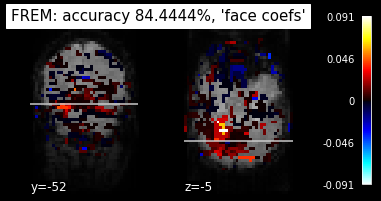

In [7]:
from nilearn.plotting import plot_stat_map

plot_stat_map(decoder.coef_img_["face"], 
              background_img,
              title="FREM: accuracy %g%%, 'face coefs'" % accuracy,
              cut_coords=(-52, -5), 
              display_mode="yz")

Compare the results with the ones obtained with a standard decoder:

In [8]:
from nilearn.decoding import Decoder

d = Decoder(estimator='svc',
            mask=data_files.mask,
            cv=10)
d.fit(X_train, y_train)

In [9]:
y_pred = d.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("Decoder classification accuracy : %g%%" % accuracy)

Decoder classification accuracy : 83.3333%


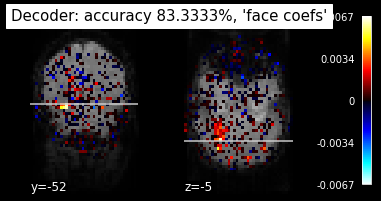

In [10]:
plot_stat_map(d.coef_img_["face"],
              background_img,
              title="Decoder: accuracy %g%%, 'face coefs'" % accuracy,
              cut_coords=(-52, -5), 
              display_mode="yz")